# Fast Directional Radiosity

This examples shows a simple diffuse simulation of a shoebox room and compare the the result with the analytical solution.
First we import all our dependencies.

In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt
#import plotly.graph_objects as go

%matplotlib inline
# %matplotlib ipympl

Lets define our room and source position.

In [2]:
# Define parameters
X = 5
Y = 6
Z = 4
patch_size = 1
ir_length_s = 1
time_resolution = 1/1000
max_order_k = 150
speed_of_sound = 343.2
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = np.array([2, 3, 2])

Let's create the instance of the simulation class called ``DirectionalRadiosityFast`` from the previously defined walls.

In [3]:
# create object
radiosity_fast = sp.DirectionalRadiosityFast.from_polygon(walls, patch_size)


Now we define the scattering coefficient to be 1 for each wall:

In [4]:
# create directional scattering data (totally diffuse)

#brdf surface with more points
directions = pf.samplings.sph_gaussian(sh_order=5)
directions = directions[directions.z > 0 ]
sources = directions
receivers = directions

frequencies = np.array([1000])
brdf = sp.brdf.create_from_scattering(
    sources, receivers, pf.FrequencyData(0.5, frequencies))

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), brdf, sources, receivers)

/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_51431/3247115377.py:4: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  directions = pf.samplings.sph_gaussian(sh_order=5)
/Users/riopradipto/anaconda3/envs/Acoustics/lib/python3.11/site-packages/pyfar/samplings/samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
/Users/riopradipto/anaconda3/envs/Acoustics/lib/python3.11/site-packages/pyfar/classes/coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order
/var/folders/vp/j1zzmqmx3lnb6s6ydlmz13_c0000gn/T/ipykernel_51431/3247115377.py:14: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


The air attenuation and absorption can be defined as well.

In [5]:
# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(brdf.frequencies),
        brdf.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(brdf.frequencies)+absorption,
        brdf.frequencies))


Now the simulation start, first the geometry is baked, where all patch to patch relationships are precalculated. E.g. Form-factor including the geometrical relationship between the patches as well as the BRDFs. This is the most heavy part of the simulation and is independent of the source and receiver position.

In [6]:
# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(ff_method="universal",algorithm="order")


OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/riopradipto/anaconda3/envs/Acoustics/lib/python3.11/site-packages/sparrowpy/radiosity_fast/form_factor.py:208: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  form_factors[i,j] = calc_form_factor(


Afterwards the source energy is initialized.

In [7]:

radiosity_fast.init_source_energy(source_pos,ff_method="universal",algorithm="order")

Next we calculate the energy exchange between the patches, then we can collect the energy at the receiver.

In [8]:
radiosity_fast.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        histogram_time_resolution=time_resolution,
        histogram_length=ir_length_s, algorithm="order",
        max_depth=max_order_k )

The energy is collected at the receiver, this is quite fast and can be done for as many receivers as required.

In [10]:
patch_index = 0
time_sample = 100  # or loop over time
lobe = radiosity_fast.E_matrix_total[0:1, :, :, 0:100].sum(axis=0)
#lobe = np.nan_to_num(l)
print(radiosity_fast.E_matrix_total.shape)
print(lobe)

print(radiosity_fast._patch_to_wall_ids)
#print(radiosity_fast.wal)
wall_patch_ids = np.where(radiosity_fast._patch_to_wall_ids == 4)[0]
print(wall_patch_ids)


(148, 36, 1, 1000)
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.86692343e+19
   1.22765431e+20 4.86340613e+20]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.28039624e-07
   3.95861639e-07 3.66126772e-07]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.23804737e-07
   2.99516348e-07 2.77129359e-07]]

 ...

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.98726499e-03
   9.52006200e-03 1.00823058e-02]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.41698787e-07
   6.86009750e-07 6.34518325e-07]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.43225522e-07
   8.72470533e-07 8.07219206e-07]]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[100 101 102 103 104 105 106 107 108 109 110 111 112 113

1000


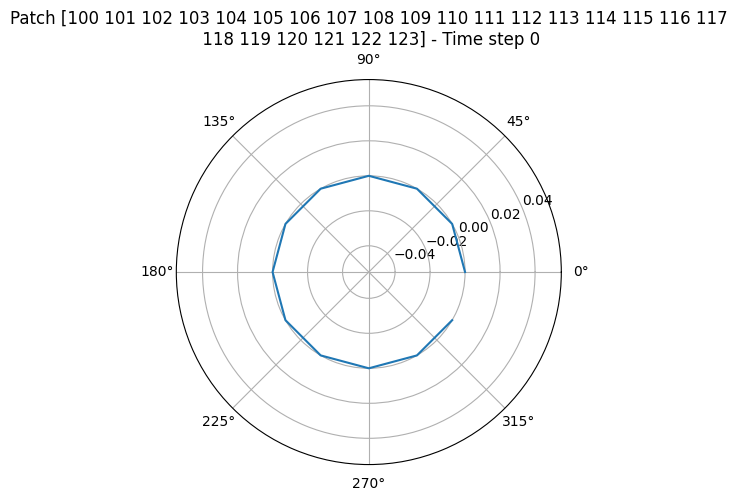

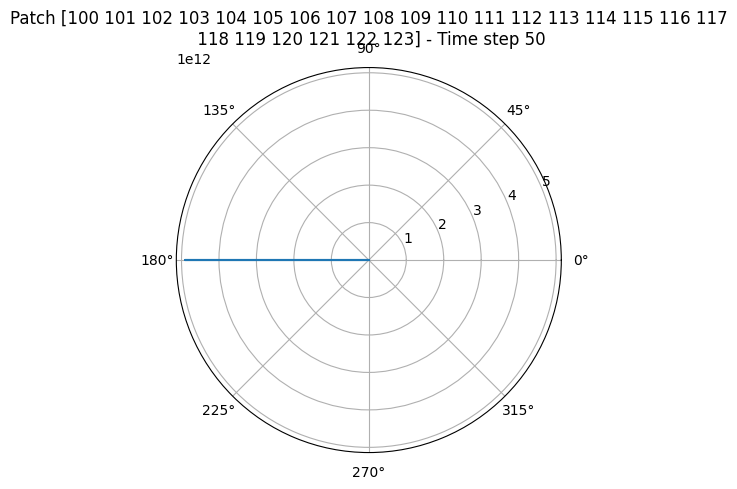

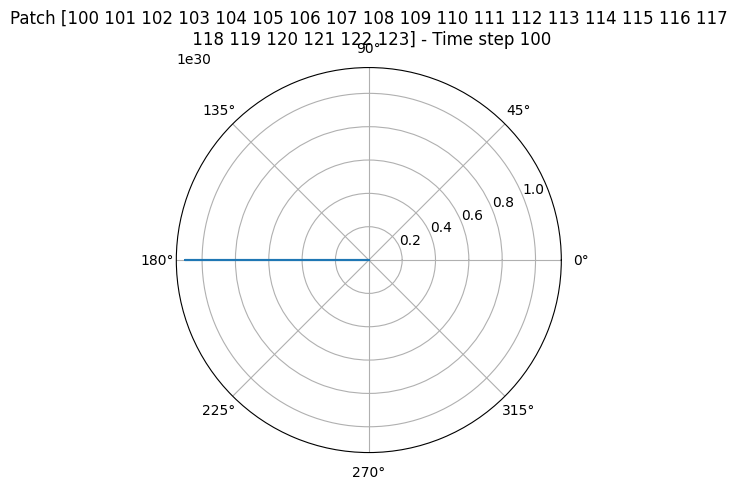

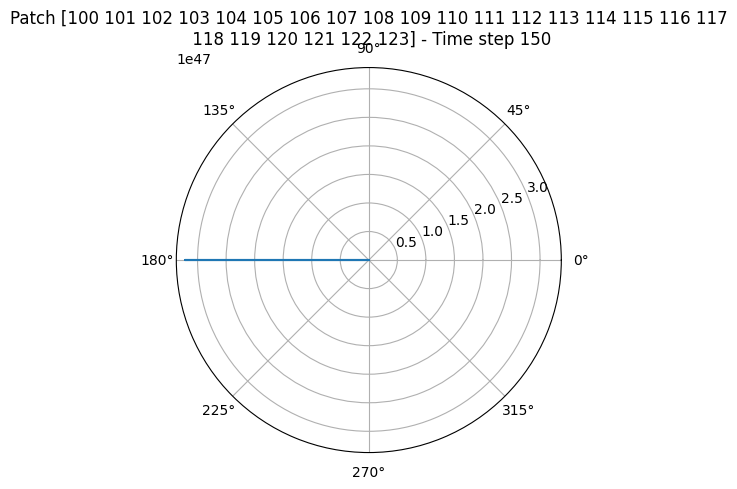

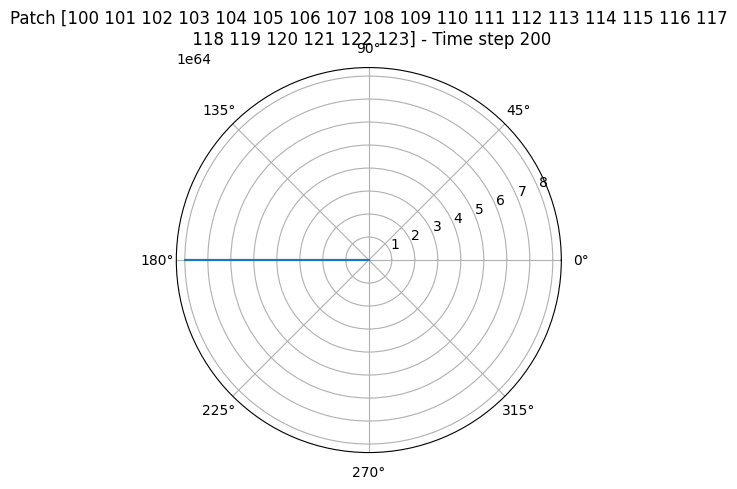

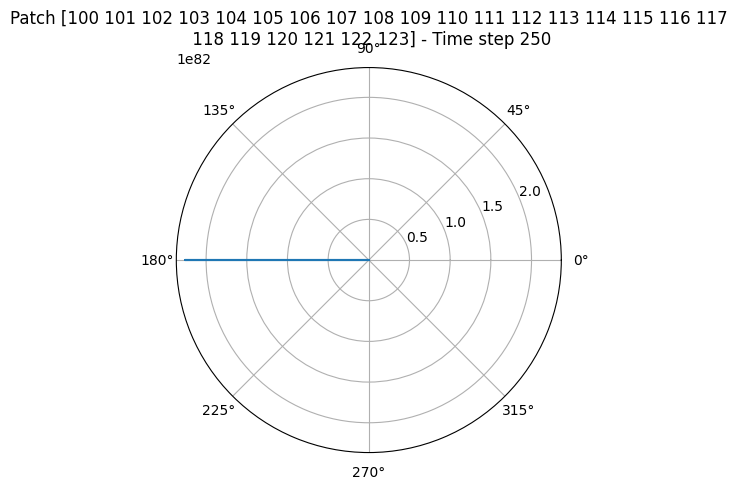

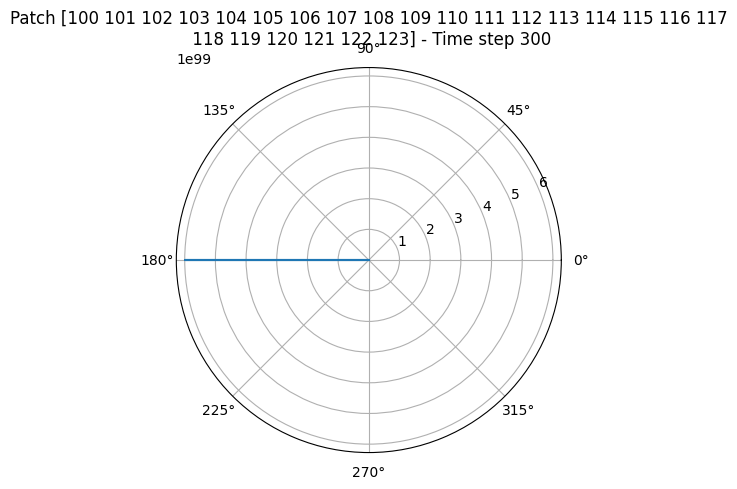

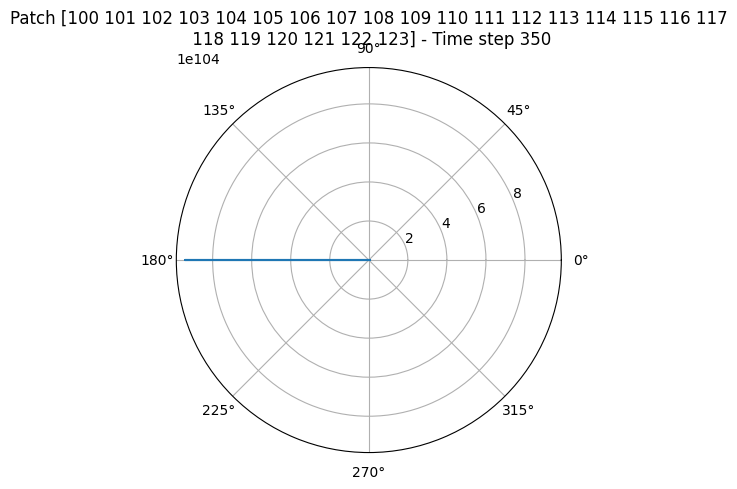

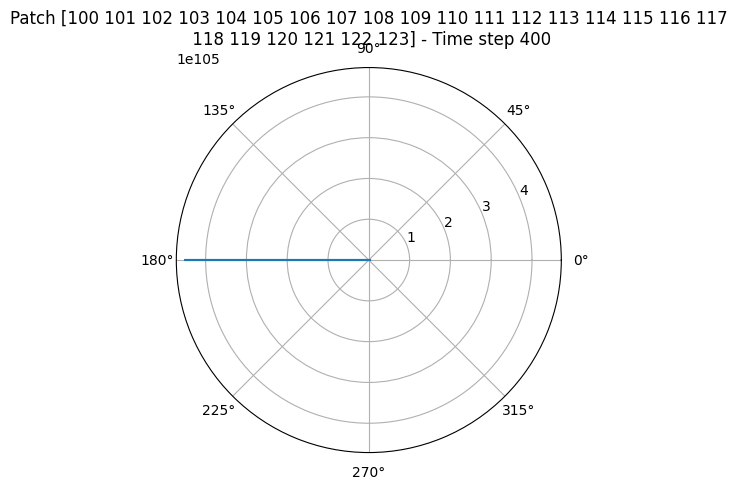

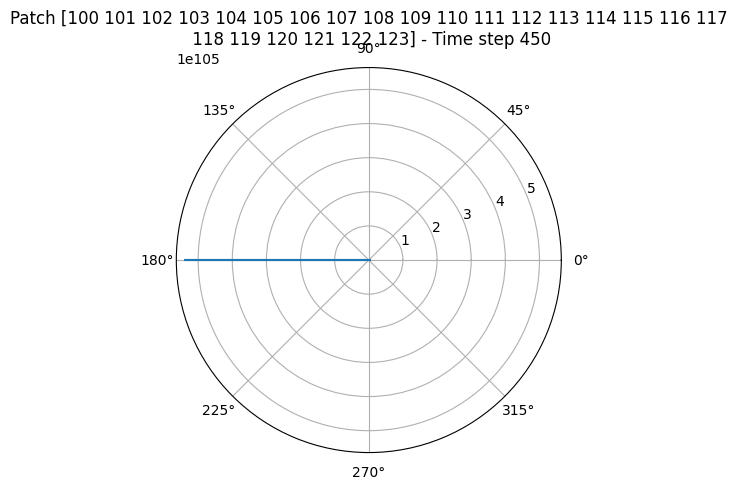

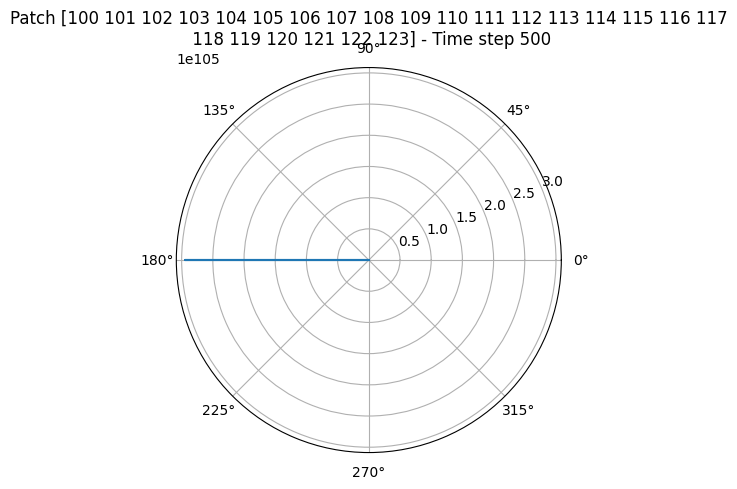

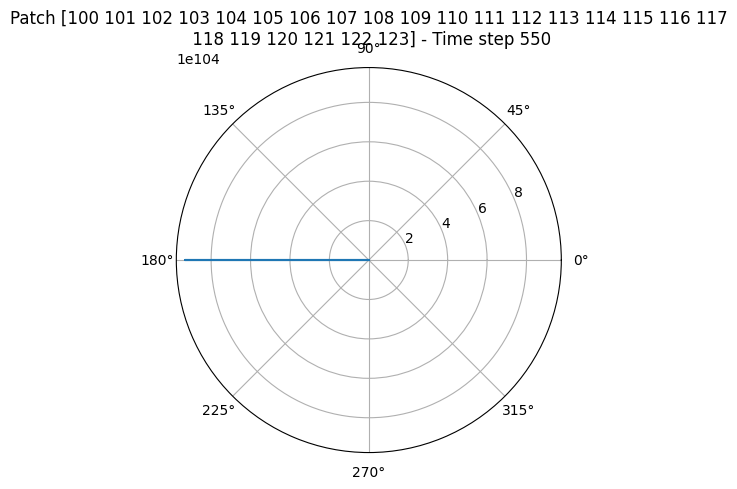

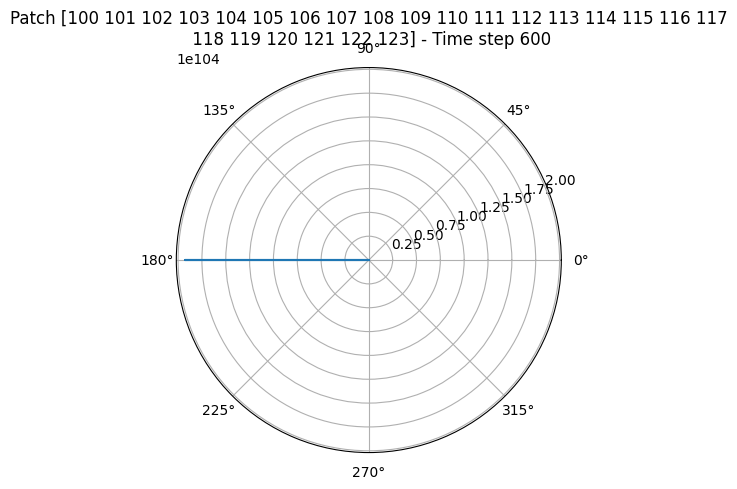

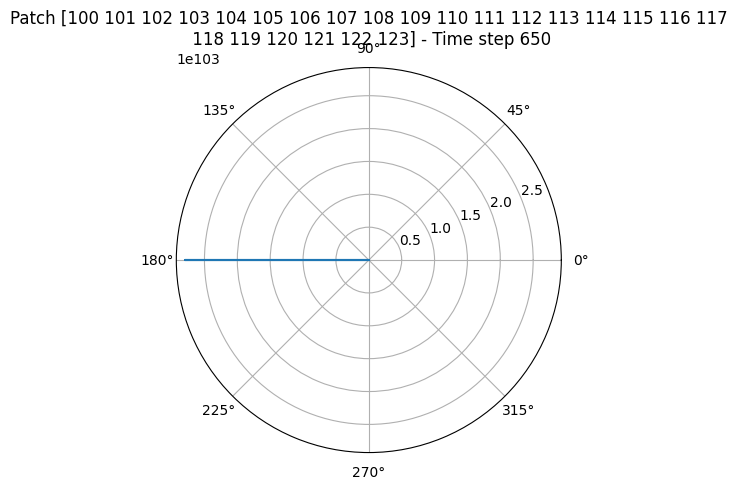

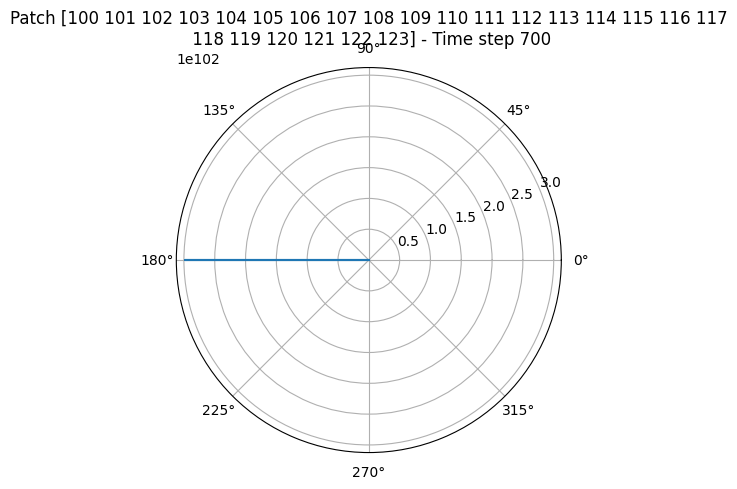

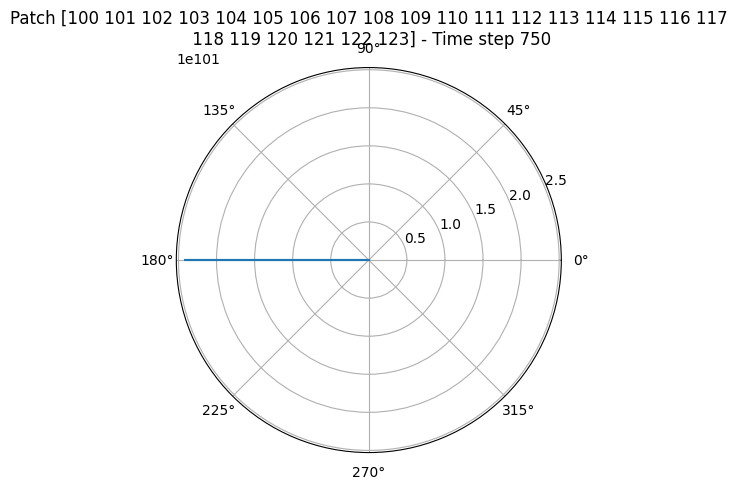

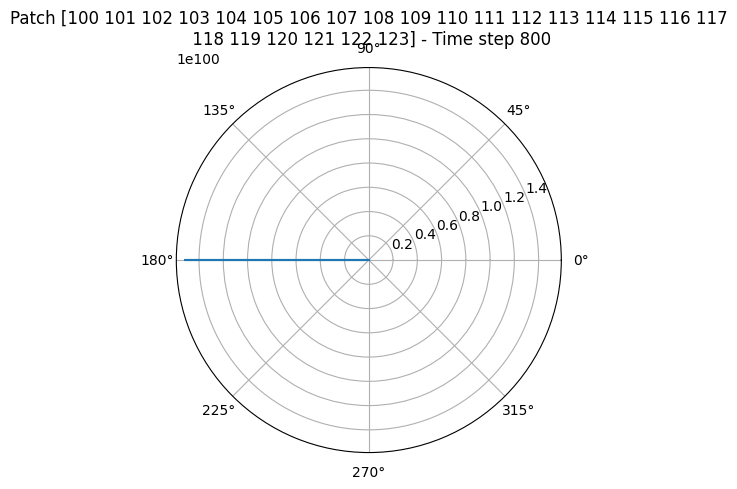

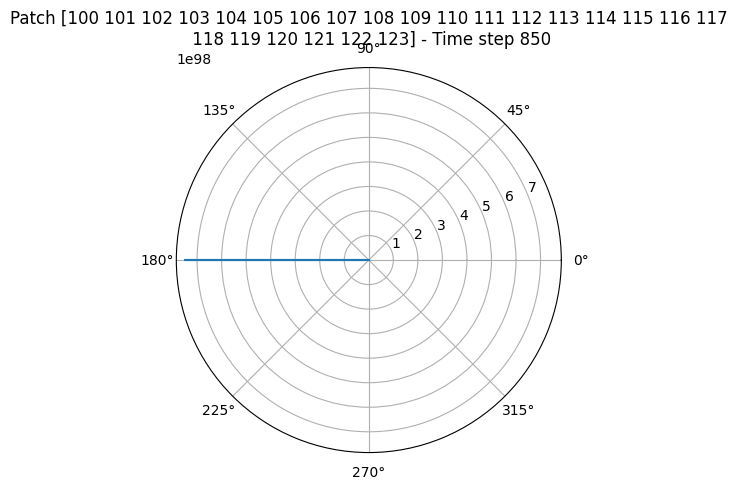

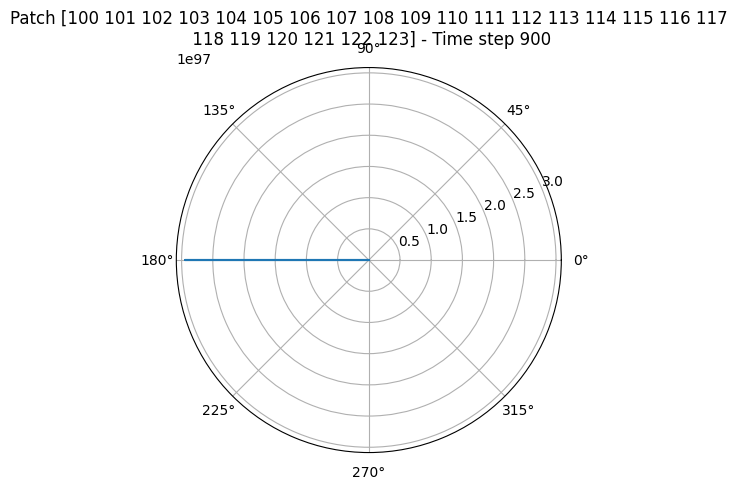

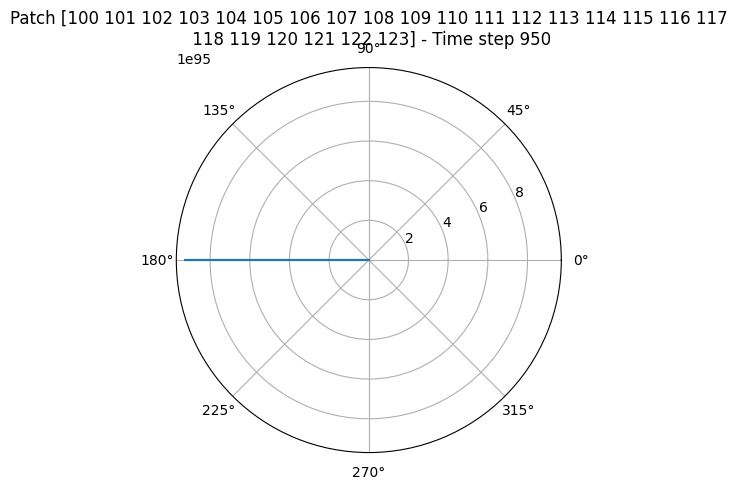

[[ 0.97111322  0.          0.23861919]
 [ 0.7502014   0.          0.66120939]
 [ 0.36124867  0.          0.93246951]
 [ 0.84100872  0.48555661  0.23861919]
 [ 0.64969347  0.3751007   0.66120939]
 [ 0.31285053  0.18062434  0.93246951]
 [ 0.48555661  0.84100872  0.23861919]
 [ 0.3751007   0.64969347  0.66120939]
 [ 0.18062434  0.31285053  0.93246951]
 [ 0.          0.97111322  0.23861919]
 [ 0.          0.7502014   0.66120939]
 [ 0.          0.36124867  0.93246951]
 [-0.48555661  0.84100872  0.23861919]
 [-0.3751007   0.64969347  0.66120939]
 [-0.18062434  0.31285053  0.93246951]
 [-0.84100872  0.48555661  0.23861919]
 [-0.64969347  0.3751007   0.66120939]
 [-0.31285053  0.18062434  0.93246951]
 [-0.97111322  0.          0.23861919]
 [-0.7502014   0.          0.66120939]
 [-0.36124867  0.          0.93246951]
 [-0.84100872 -0.48555661  0.23861919]
 [-0.64969347 -0.3751007   0.66120939]
 [-0.31285053 -0.18062434  0.93246951]
 [-0.48555661 -0.84100872  0.23861919]
 [-0.3751007  -0.64969347

In [11]:
import numpy as np

patch_index = wall_patch_ids
n_samples = radiosity_fast.E_matrix_total.shape[3]
print(n_samples)

for t in range(0, n_samples, 50):  # every 10 time samples
    lobe = radiosity_fast.E_matrix_total[patch_index, :, :, t].sum(axis=0)  # (directions × freq bins)
    avg_lobe = lobe.mean(axis=1)  # average over frequency

    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.plot(receivers.azimuth, avg_lobe)
    ax.set_title(f"Patch {patch_index} - Time step {t}")
    plt.show()

print(directions.cartesian)

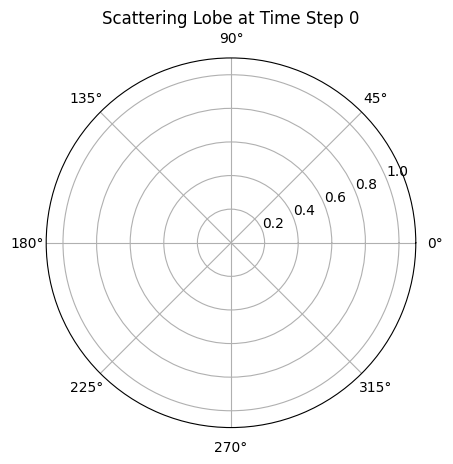

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# === INPUTS (customize as needed) ===
patch_ids = [wall_patch_ids]  # or use np.where(...) for a wall
n_time = radiosity_fast.E_matrix_total.shape[-1]
receiver_azimuth = np.mod(receivers.azimuth, 2 * np.pi)

# === Lobe Extractor Function ===
def get_lobe_at_time(t_index):
    energy = radiosity_fast.E_matrix_total[patch_ids, :, :, t_index].sum(axis=0)  # (patches, dirs, bins)
    lobe = energy.mean(axis=(0, 2))  # mean over patches and bins
    return lobe / (np.max(lobe) + 1e-9)

# === Set Up Plot ===
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
line, = ax.plot([], [], lw=2)
ax.set_ylim(0, 1.1)
ax.set_title("Scattering Lobe Evolution")

# === Animation Function ===
def update(frame):
    lobe = get_lobe_at_time(frame)
    line.set_data(receiver_azimuth, lobe)
    ax.set_title(f"Scattering Lobe at Time Step {frame}")
    return line,

# === Create Animation ===
ani = FuncAnimation(
    fig, update, frames=range(0, n_time, 2), blit=True, interval=100)

# === Save or Show ===
plt.show()

# Optional: Save as MP4 or GIF
ani.save("scattering_lobe_evolution.mp4", writer="ffmpeg", fps=60)
#ani.save("scattering_lobe_evolution.gif", writer="pillow", fps=10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_scattering_lobe_3d(E_matrix_total, receiver_directions, patch_index, time_index):
    """
    Plots the 3D scattering lobe at a given patch and time step.
    
    Parameters:
        E_matrix_total : np.ndarray
            Shape: (n_patches, n_directions, n_bins, n_samples)
        receiver_directions : object
            Must have `.azimuth` and `.colatitude` in radians, shape (n_directions,)
        patch_index : int
            Patch index to visualize
        time_index : int
            Time sample index to visualize
    """

    # Average over frequency bins
    energy = E_matrix_total[patch_index, :, :, time_index].mean(axis=1)

    # Normalize energy for visualization
    energy /= np.max(energy) + 1e-9

    # Spherical to Cartesian
    az = receiver_directions.azimuth
    col = receiver_directions.colatitude
    r = energy

    x = r * np.sin(col) * np.cos(az)
    y = r * np.sin(col) * np.sin(az)
    z = r * np.cos(col)

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2, antialiased=True)

    ax.set_title(f"Scattering Lobe (Patch {patch_index}, Time {time_index})")
    ax.set_box_aspect([1,1,1])
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
plot_scattering_lobe_3d(radiosity_fast.E_matrix_total, receivers, patch_index=0, time_index=30)

In [ ]:
print(receivers)

In [ ]:
import numpy as np
import plotly.graph_objects as go

# === INPUT ===
patch_ids = wall_patch_ids  # or np.where(self._patch_to_wall_ids == 3)[0]
E = radiosity_fast.E_matrix_total  # shape: (n_patches, n_dirs, n_bins, n_time)
receiver_dirs = receivers  # with azimuth, colatitude

# === Spherical to Cartesian directions ===
az = receiver_dirs.azimuth
col = receiver_dirs.colatitude
x_dirs = np.sin(col) * np.cos(az)
y_dirs = np.sin(col) * np.sin(az)
z_dirs = np.cos(col)

# === Lobe function ===
def get_lobe(t):
    lobe = E[patch_ids, :, :, t]
    lobe = lobe.mean(axis=(0, 2))  # mean over patches and bins
    lobe /= np.max(lobe) + 1e-9
    return lobe

# === Create up to 100 frames ===
max_frames = 1000
n_time = E.shape[-1]
step = max(n_time // max_frames, 1)

frames = []
sliders_dict = {
    "active": 0,
    "steps": [],
    "currentvalue": {"prefix": "Time step: "},
}

for i, t in enumerate(range(0, n_time, step)):
    lobe = get_lobe(t)
    x = x_dirs * lobe
    y = y_dirs * lobe
    z = z_dirs * lobe
    frame = go.Frame(
        data=[go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=3, color=lobe, colorscale='Viridis'))],
        name=str(i)
    )
    frames.append(frame)
    sliders_dict["steps"].append({
        "args": [[str(i)], {"frame": {"duration": 0, "redraw": True},
                            "mode": "immediate"}],
        "label": str(i),
        "method": "animate",
    })

# === Initial frame ===
lobe0 = get_lobe(0)
x0 = x_dirs * lobe0
y0 = y_dirs * lobe0
z0 = z_dirs * lobe0

# === Figure with slider ===
fig = go.Figure(
    data=[go.Scatter3d(
        x=x0, y=y0, z=z0, mode='markers',
        marker=dict(size=3, color=lobe0, colorscale='Viridis')
    )],
    layout=go.Layout(
        title="3D Scattering Lobe Evolution",
        scene=dict(aspectmode='cube'),
        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 50, "redraw": True},
                                "fromcurrent": True, "mode": "immediate"}],
            }],
            "showactive": False
        }],
        sliders=[sliders_dict]
    ),
    frames=frames
)

fig.show()


In [ ]:

ir_fast = np.sum(radiosity_fast.collect_receiver_energy(
    receiver_pos=receiver_pos,
    speed_of_sound=speed_of_sound,
    histogram_time_resolution=time_resolution,
    propagation_fx=True,
    ),axis=1)[0]
n_samples = ir_fast.shape[-1]
reverberation_fast = pf.TimeData(ir_fast, np.arange(n_samples)*time_resolution)

print(reverberation_fast)

To compare our energy time curve, we can calculate the analytical solution based on the diffuse sound field in the room after Kuttruff.

In [ ]:

S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h:.1f}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT:.2f}s')
E_reverb_analytical = 4/A
t = reverberation_fast.times
# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.TimeData(reverberation_analytic, t)

Lets compare these to results.

In [ ]:
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')

pf.plot.time(
    reverberation_fast, dB=True, log_prefix=10,
    label='simulated',
    linestyle='--')

plt.legend()
plt.show()

If the order would be increased, this would match even after 0.5s.


In [ ]:
%load_ext watermark
%watermark -v -m -iv